_한국어로 기계번역됨_



# 노드에서 그래프 상태 업데이트 방법

이 가이드는 LangGraph에서 [상태](../../concepts/low_level/#state)를 정의하고 업데이트하는 방법을 설명합니다. 우리는 다음을 시연할 것입니다:

1. 상태를 사용하여 그래프의 [스키마](../../concepts/low_level/#schema)를 정의하는 방법
2. [리듀서](../../concepts/low_level/#reducers)를 사용하여 상태 업데이트가 처리되는 방식을 제어하는 방법

우리는 예제에서 [메시지](../../concepts/low_level/#messagesstate)를 사용할 것입니다. 이는 많은 LLM 애플리케이션을 위한 상태의 다재다능한 형식을 나타냅니다. 자세한 내용은 [개념 페이지](../../concepts/low_level/#working-with-messages-in-graph-state)를 참조하세요.

## 설정

먼저, langgraph를 설치합시다:


In [ ]:
%%capture --no-stderr
%pip install -U langgraph


<div class="admonition tip">
     <p class="admonition-title">더 나은 디버깅을 위해 <a href="https://smith.langchain.com">LangSmith</a> 설정하기</p>
     <p style="padding-top: 5px;">
         LangSmith에 가입하여 문제를 신속하게 파악하고 LangGraph 프로젝트의 성능을 향상시키세요. LangSmith를 사용하면 LangGraph로 구축한 LLM 앱을 디버깅하고, 테스트하며, 모니터링하기 위해 추적 데이터를 활용할 수 있습니다. 시작하는 방법에 대한 자세한 내용은 <a href="https://docs.smith.langchain.com">문서</a>를 참조하세요.
     </p>
 </div>


## 예시 그래프

### 상태 정의
LangGraph에서 [상태](../../concepts/low_level/#state)는 `TypedDict`, `Pydantic` 모델 또는 데이터 클래스가 될 수 있습니다. 아래에서는 `TypedDict`를 사용할 것입니다. Pydantic 사용에 대한 자세한 내용은 [이 가이드를](../../how-tos/state-model) 참조하십시오.

기본적으로, 그래프는 입력 및 출력 스키마가 동일하며, 상태는 해당 스키마를 결정합니다. 구별된 입력 및 출력 스키마를 정의하는 방법에 대한 자세한 내용은 [이 가이드를](../../how-tos/input_output_schema/) 참조하십시오.

간단한 예제를 고려해보겠습니다:


In [1]:
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict


class State(TypedDict):
    messages: list[AnyMessage]
    extra_field: int


이 상태는 [메시지](https://python.langchain.com/docs/concepts/messages/) 객체 목록과 추가된 정수 필드를 추적합니다.

### 그래프 구조 정의

단일 노드로 구성된 예제 그래프를 만들어 봅시다. 우리의 [노드](../../concepts/low_level/#nodes)는 그래프의 상태를 읽고 이를 업데이트하는 Python 함수에 불과합니다. 이 함수의 첫 번째 인수는 항상 상태가 됩니다.


In [2]:
from langchain_core.messages import AIMessage


def node(state: State):
    messages = state["messages"]
    new_message = AIMessage("Hello!")

    return {"messages": messages + [new_message], "extra_field": 10}


이 노드는 단순히 메시지를 우리 메시지 목록에 추가하고, 추가 필드를 채웁니다.

!!! 중요

    노드는 상태를 변형하는 대신 상태에 직접 업데이트를 반환해야 합니다.

다음으로 이 노드를 포함하는 간단한 그래프를 정의해 보겠습니다. 우리는 [StateGraph](../../concepts/low_level/#stategraph)를 사용하여 이 상태에서 작동하는 그래프를 정의합니다. 그런 다음 [add_node](../../concepts/low_level/#messagesstate)를 사용하여 우리의 그래프를 채웁니다.


In [3]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(State)
graph_builder.add_node(node)
graph_builder.set_entry_point("node")
graph = graph_builder.compile()


LangGraph는 그래프를 시각화하기 위한 내장 도구를 제공합니다. 우리의 그래프를 살펴봅시다. 시각화에 대한 자세한 내용은 [이 가이드](../../how-tos/visualization)를 참조하세요.


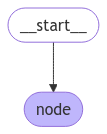

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


이 경우, 우리의 그래프는 단일 노드만 실행합니다.


### 그래프 사용

간단한 호출을 진행해봅시다:


In [5]:
from langchain_core.messages import HumanMessage

result = graph.invoke({"messages": [HumanMessage("Hi")]})
result


{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Hello!', additional_kwargs={}, response_metadata={})],
 'extra_field': 10}

다음 사항에 유의하세요:

- 우리는 상태의 단일 키를 업데이트하여 호출을 시작했습니다.
- 호출 결과로 전체 상태를 받습니다.

편의성을 위해 우리는 [메시지 객체](https://python.langchain.com/docs/concepts/messages/)의 내용을 자주 예쁘게 출력하여 확인합니다.


In [6]:
for message in result["messages"]:
    message.pretty_print()


================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello!


## 리듀서를 통한 프로세스 상태 업데이트

상태의 각 키는 노드의 업데이트가 적용되는 방식을 제어하는 독립적인 [리듀서](../../concepts/low_level/#reducers) 함수를 가질 수 있습니다. 리듀서 함수가 명시적으로 지정되지 않은 경우에는 해당 키에 대한 모든 업데이트가 이를 덮어쓰는 것으로 간주됩니다.

`TypedDict` 상태 스키마의 경우, 상태의 해당 필드를 리듀서 함수로 주석 처리하여 리듀서를 정의할 수 있습니다.

이전 예제에서 우리의 노드는 메시지를 추가하여 상태의 `"messages"` 키를 업데이트했습니다. 아래에서는 이 키에 리듀서를 추가하여 업데이트가 자동으로 추가되도록 설정합니다:


In [7]:
from typing_extensions import Annotated


def add(left, right):
    """Can also import `add` from the `operator` built-in."""
    return left + right


class State(TypedDict):
    # highlight-next-line
    messages: Annotated[list[AnyMessage], add]
    extra_field: int


이제 우리의 노드를 단순화할 수 있습니다:


In [8]:
def node(state: State):
    new_message = AIMessage("Hello!")
    # highlight-next-line
    return {"messages": [new_message], "extra_field": 10}


In [10]:
from langgraph.graph import START


graph = StateGraph(State).add_node(node).add_edge(START, "node").compile()

result = graph.invoke({"messages": [HumanMessage("Hi")]})

for message in result["messages"]:
    message.pretty_print()


================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello!


### 메시지 상태

실제로 메시지 목록을 업데이트할 때 추가로 고려해야 할 사항이 있습니다:

- 상태에서 기존 메시지를 업데이트하고 싶을 수 있습니다.
- [메시지 형식](../../concepts/low_level/#using-messages-in-your-graph)에 대한 단축 형식을 수용하고 싶을 수 있습니다. 예를 들어 [OpenAI 형식](https://python.langchain.com/docs/concepts/messages/#openai-format)입니다.

LangGraph에는 이러한 고려 사항을 처리하는 내장 리듀서 `add_messages`가 포함되어 있습니다:


In [11]:
from langgraph.graph.message import add_messages


class State(TypedDict):
    # highlight-next-line
    messages: Annotated[list[AnyMessage], add_messages]
    extra_field: int


def node(state: State):
    new_message = AIMessage("Hello!")
    return {"messages": [new_message], "extra_field": 10}


graph = StateGraph(State).add_node(node).set_entry_point("node").compile()


In [12]:
# highlight-next-line
input_message = {"role": "user", "content": "Hi"}

result = graph.invoke({"messages": [input_message]})

for message in result["messages"]:
    message.pretty_print()


================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello!


이는 [채팅 모델](https://python.langchain.com/docs/concepts/chat_models/)과 관련된 응용 프로그램을 위한 다용도 상태 표현입니다. LangGraph에는 편리함을 위해 미리 구축된 `MessagesState`가 포함되어 있어, 이를 통해 다음을 가질 수 있습니다:


In [13]:
from langgraph.graph import MessagesState


class State(MessagesState):
    extra_field: int


## 다음 단계

- [Graph API 기본](../../how-tos/#graph-api-basics) 가이드를 계속 진행합니다.
- [상태 관리](../../how-tos/#state-management)에 대한 자세한 내용을 확인합니다.
